# pH-rate Data

This workbook contains the code and imports the data to explore the pH rate profiles in the paper.

The data being plotted is from "On the Rearrangement in Dioxane/Water of (*Z*)-Arylhydrazones of 5-Amino-3-benzoyl-1,2,4-oxadiazole into (2-Aryl-5-phenyl-2*H*-1,2,3-triazol-4-yl)ureas: Substituent Effects on the Different Reaction Pathways." F. D'Anna, V. Frenna, G. Macaluso, S. Marullo, S. Morganti, V. Pace, D. Spinelli, R. Spisani, C. Tavani, *J. Org. Chem.*, **2006**, *71*, 5616-5624. https://doi.org/10.1021/jo0605849

The data is found in tables within the supplementary material at https://ndownloader.figstatic.com/files/4775281


## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [1]:
##############################################################
### Set up libraries and global variables
##############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit


github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_23/data/"
#github_location = "./data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

In [2]:
############################################
### Read in data from literature example 
############################################

datafile = "1c-data.csv"   # Change this file name as you swith data sets

df = pd.read_csv(github_location + datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 


#########################################################
### Determine scale from column header name           
#########################################################

if df.columns[0] == "k(A,R)x10^5":
    name = "k(A,R)x10^5"
    colname = df.columns[0]
    factor = 10**-5
elif df.columns[0] == "k(A,R)x10^4":
    name = "k(A,R)x10^4"
    colname = df.columns[0]
    factor = 10**-4
else:
    name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
    colname = df.columns[0]
    factor = 0


###############################
### Calculations            
###############################

df["log_k"] = np.log10(df[name] * factor)   # if 'name' does not match a column header in 'df' there will be an error

#display(df)

## Plot and Curve Fits

The code below will extract the x,y data for our plots and make the plot.  There is also code to fit the data according to the three rate constants of the reaction and acidity.

Ka = 0.47 pm 0.078
kOH = 2.18 pm 0.0632
kH2O = 1.24E-05 pm 4.12E-07
kH = 0.00233 pm 0.000304
pKa = 0.33


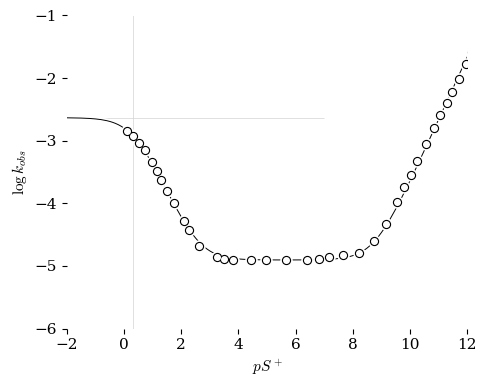

In [25]:
LineFitBoolean = True   ### set to 'False' for no curve fit

##############################################################
### Define a function that calculates the equation being
### used for the model that will be fit to the data.
##############################################################

def model(pH, Ka = 0.1, kOH=0.1, kH2O = 0.1, kH = 0.1):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = (kOH * (KW/H) + kH2O + kH * (H/Ka))*(Ka/(Ka + H))
    return(np.log10(k_obs))


#####################################################
### Get series of data to plot from the dataframe 
#####################################################

x = list(df.index)
y = list(df["log_k"])


##################################################
### Curve Fit                                
##################################################

if LineFitBoolean:

    ### Set bounds so rate consatnts are never negative and constrain Ka value if needed
    min_Ka = 0.01
    max_Ka = 10       # One data set will want infinite Ka value because of no curvature in that region. Limit max value.
    k_min = 0
    k_max = np.inf

    lower_bounds = [min_Ka, k_min, k_min, k_min]    # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [max_Ka, k_max, k_max, k_max] # upper bounds for Ka but no upper bounds for kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)

    ### Perform the curve fit. Will return a list of parameters and an array of statistical info.
    parameters, pcov = curve_fit(model, x, y, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits

    [Ka, kOH, kH2O, kH] = parameters  ### Assign the parameter list to values
    perr = np.sqrt(np.diag(pcov))     ### Determine standard deviations from covariance matrix


    ################################################################
    ### make a line from the parameters and the model            
    ### this would be the line of the curve fit when plotted     
    ################################################################

    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-2, 12 + step, step)     # make an array of points to calculate y-values from
    fity = model(x1, Ka, kOH, kH2O, kH)     # Calculate those y-values using the model


##################################################
### Setup a figure and choose a stylesheet     
##################################################

style_file = "tufte.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   

############################
### Set labels and scale 
############################

ax.set(
#    title="pH rate profilr",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$pS^+$",                
          xlim=[-2,12],                  
          ylim=[-6,-1]
         )

#########################################
### Plot the data                     
#########################################


#plt.vlines([1,3.8,11.5],-6,-1, colors = "lightgray", linewidth = 0.5)

ax.scatter(x,y, s=64, color="white", zorder=2)
ax.scatter(x,y, s=32, color="black", zorder=2)
ax.scatter(x,y, s=16, color="white", alpha = 1.0, zorder=2)

plt.vlines(-np.log10(Ka), -6,-1, colors = "lightgray", linewidth = 0.5, zorder=0)
plt.hlines(np.log10(kH), -2,7, colors = "lightgray", linewidth = 0.5, zorder=0)

pH_x = 10**-np.array(x)
kHline_y = kH/Ka*pH_x
#ax.plot(-np.log10(pH_x), np.log10(kHline_y), color='lightgray', zorder=0, linewidth=0.5)




#########################################
### Plot the line fit.                
#########################################
if LineFitBoolean:
    ax.plot(x1, fity, color='white', zorder=1, linewidth=3)
    ax.plot(x1, fity, color='black', zorder=1, linewidth=0.7)

    #######################################################
    ### Print out Parameters and standard deviations    
    #######################################################

    print(f"Ka = {Ka:0.2G} pm {perr[0]:0.2G}")
    print(f"kOH = {kOH:0.3G} pm {perr[1]:0.3G}")
    print(f"kH2O = {kH2O:0.3G} pm {perr[2]:0.3G}")
    print(f"kH = {kH:0.3G} pm {perr[3]:0.3G}")
    print(f"pKa = {-np.log10(Ka):0.2f}")

#############################
### Output the final plot 
#############################

fig.savefig("plot_pH.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots

